In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)

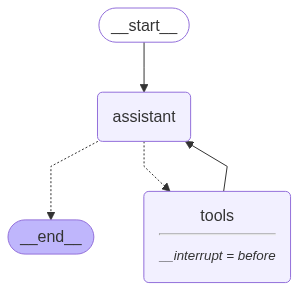

In [36]:
from IPython.display import Image, display

from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.messages import SystemMessage, HumanMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")
builder.add_edge("assistant", END)

graph = builder.compile(checkpointer=MemorySaver(), interrupt_before=["tools"])


display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [39]:
input_message = {"messages": [HumanMessage(content="Multiply 2 and 3", id="2")]}
thread = {'configurable': {'thread_id': '1'}}
for event in graph.stream(input_message, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_CTg7vmAnJGXVPfN1MbY3Q5wN)
 Call ID: call_CTg7vmAnJGXVPfN1MbY3Q5wN
  Args:
    a: 2
    b: 3


In [40]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_CTg7vmAnJGXVPfN1MbY3Q5wN)
 Call ID: call_CTg7vmAnJGXVPfN1MbY3Q5wN
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [41]:
state = graph.get_state(config=thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 10 and 7', additional_kwargs={}, response_metadata={}, id='1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_opdtYWAl1HHtsjJOQnnU1Xu1', 'function': {'arguments': '{"a":10,"b":7}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbKhfje8LeWItpJPF5CHivJkRTK9j', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5a524f5a-67ca-4650-89c6-d2f7626124e7-0', tool_calls=[{'name': 'multiply', 'args': {'a': 10, 'b': 7}, 'id': 'call_opdtYWAl1HHtsjJOQnnU1Xu1', 'type': 'too

In [45]:
graph.update_state(thread, {"messages": [HumanMessage(content="No, actually multiply 11 and 6!", id='1')]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f039f2e-a65f-651a-800a-72e5f7f41bd9'}}

In [47]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

No, actually multiply 11 and 6!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_opdtYWAl1HHtsjJOQnnU1Xu1)
 Call ID: call_opdtYWAl1HHtsjJOQnnU1Xu1
  Args:
    a: 10
    b: 7
================================= Tool Message =================================
Name: multiply

70
================================== Ai Message ==================================

The result of multiplying 10 and 7 is 70.
================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_CTg7vmAnJGXVPfN1MbY3Q5wN)
 Call ID: call_CTg7vmAnJGXVPfN1MbY3Q5wN
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message =============

In [50]:
for event in graph.stream({"messages": [HumanMessage(content="No, actually multiply 17 and 6!")]}, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 17 and 6!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ffiz6yr4cLat4o3h7X3TedmF)
 Call ID: call_ffiz6yr4cLat4o3h7X3TedmF
  Args:
    a: 17
    b: 6


In [51]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_ffiz6yr4cLat4o3h7X3TedmF)
 Call ID: call_ffiz6yr4cLat4o3h7X3TedmF
  Args:
    a: 17
    b: 6
================================= Tool Message =================================
Name: multiply

102
================================== Ai Message ==================================

The result of multiplying 17 and 6 is 102.


In [52]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

No, actually multiply 11 and 6!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_opdtYWAl1HHtsjJOQnnU1Xu1)
 Call ID: call_opdtYWAl1HHtsjJOQnnU1Xu1
  Args:
    a: 10
    b: 7
================================= Tool Message =================================
Name: multiply

70
================================== Ai Message ==================================

The result of multiplying 10 and 7 is 70.
================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_CTg7vmAnJGXVPfN1MbY3Q5wN)
 Call ID: call_CTg7vmAnJGXVPfN1MbY3Q5wN
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message =============

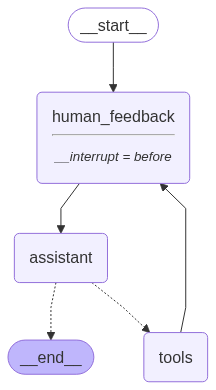

In [53]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

nothing
================================== Ai Message ==================================
Tool Calls:
  multiply (call_PdEC8R0H0u96O39mczqLG4EF)
 Call ID: call_PdEC8R0H0u96O39mczqLG4EF
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [55]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.
